## Anxiety calculation for height control experiments - trial wise
## Creating PSD files for each trial (4 files for each participant)
### Healthy Young Adult Participant 102
### Files 1, 4 have perturbation whereas files 2 and 3 have no perturbation 

## Rachneet Kaur

In [11]:
import pandas
import numpy
import mne
import time
from scipy import signal
%matplotlib inline
from matplotlib import pylab as plotter
from mne.preprocessing import ICA

In [12]:
dirname="D:\\ICDetection\\Data\\Peoria_Height_Control_Experiments\\"
eeg = "EEG\\"
notes = "Notes\\"
patient_no = "102\\"

height_files = ["PCD2018_102_2_height3.vhdr", "PCD2018_102_2_height4.vhdr", "PCD2018_102_2_height_2.vhdr"]

notes_files = ["height control1/notes.log", "height control2/notes.log", "height control3/notes.log"]
#Since log file from height2 is missing, we will only use 3, 4 and 2 for experimental results 

In [13]:
tic=time.process_time()
raw1=mne.io.read_raw_brainvision(dirname+eeg+patient_no+height_files[0], stim_channel = True)
raw2=mne.io.read_raw_brainvision(dirname+eeg+patient_no+height_files[1], stim_channel = True)
raw3=mne.io.read_raw_brainvision(dirname+eeg+patient_no+height_files[2], stim_channel = True)
toc=time.process_time()
print(str(toc-tic)+" seconds needed to import 4 height files ")

Extracting parameters from D:\ICDetection\Data\Peoria_Height_Control_Experiments\EEG\102\PCD2018_102_2_height3.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/S  3', 'Stimulus/S  9', 'Stimulus/S 10', 'Stimulus/S  2', 'Stimulus/S  5', 'Stimulus/S  1', 'Stimulus/S 13', 'Stimulus/S 15', 'Stimulus/S  8', 'Stimulus/S 11', 'Response/R  1', 'Stimulus/S  4', 'Stimulus/S  7', 'Stimulus/S 12', 'Stimulus/S  6', 'Stimulus/S 14']
Extracting parameters from D:\ICDetection\Data\Peoria_Height_Control_Experiments\EEG\102\PCD2018_102_2_height4.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Stimulus/S 12', 'Stimulus/S 11', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  5', 'Response/R  1', 'Stimulus/S 14', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S  7', 'Stimulus/S 10', 'Stimulus/S  3', 'Stimulus/S 13', 'Stimulus/S  6', 'Stimulus/S 15', 'Stimulus/S  4']
Extracting parameters from D:\ICDetection\Data\Peoria_Height_Control_Experiments\EEG\1

In [14]:
#Looking at the .vhdr files 
print("raw1: "+str(raw1.info)) #For height1
print("channel names: "+str(raw1.ch_names))
print("there are "+str(len(raw1.ch_names))+" channels")

raw1: <Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Ch1, Ch2, Ch3, Ch4, Ch5, Ch6, Ch7, Ch8, Ch9, ...
    chs : list | 72 items (EEG: 71, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 500.0 Hz
    meas_date : tuple | 2018-11-09 17:17:25 GMT
    nchan : int | 72
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    

#### Dropping the unnecessary channels 

In [15]:
number_chan = len(raw1.ch_names) #number of channels 

# Deleting the data from the 8 auxiallary channels and Channel 'STI 014'
chan_drop = ['Aux1', 'Aux2', 'Aux3', 'Aux4', 'Aux5', 'Aux6', 'Aux7', 'Aux8', 'STI 014'] #List of channels to drop
raw1.load_data()
raw2.load_data()
raw3.load_data()
raw1.drop_channels(chan_drop) #Dropping the auxillary channels 
raw2.drop_channels(chan_drop)
raw3.drop_channels(chan_drop)

Reading 0 ... 296849  =      0.000 ...   296.849 secs...
Reading 0 ... 564449  =      0.000 ...   564.449 secs...
Reading 0 ... 333199  =      0.000 ...   333.199 secs...


<RawBrainVision  |  PCD2018_102_2_height_2.eeg, n_channels x n_times : 63 x 333200 (333.2 sec), ~160.3 MB, data loaded>

#### Renaming the channels for digitization 

In [16]:
#Dictionary to map the channel names according to their location correponding to digitization file 
#Channel 21 acts as the Ground (GND) channel and it is already missing from channel names list in raw recorded EEG
map_channels = {'Ch1':'Fp1', 'Ch2':'Fz', 'Ch3':'F3', 'Ch4':'F7', 'Ch5':'LHEye', 'Ch6':'FC5', 'Ch7':'FC1', 'Ch8':'C3', 
                'Ch9':'T7', 'Ch10':'Lmastoid', 'Ch11':'CP5', 'Ch12':'CP1', 'Ch13':'Pz', 'Ch14':'P3', 'Ch15':'P7', 
                'Ch16':'O1', 'Ch17':'Oz', 'Ch18':'O2', 'Ch19':'P4', 'Ch20':'P8', 'Ch22':'CP6', 'Ch23':'CP2', 
                'Ch24':'Cz', 'Ch25':'C4', 'Ch26': 'T8', 'Ch27': 'RHEye', 'Ch28': 'FC6', 'Ch29': 'FC2',
                'Ch30':'F4', 'Ch31':'F8', 'Ch32':'Fp2', 'Ch33': 'AF7', 'Ch34':'AF3', 'Ch35':'AFz', 'Ch36':'F1', 
                'Ch37':'F5', 'Ch38':'FT7', 'Ch39':'FC3', 'Ch40':'FCz', 'Ch41':'C1', 'Ch42':'C5', 'Ch43': 'TP7',
                'Ch44': 'CP3', 'Ch45':'P1', 'Ch46':'P5', 'Ch47':'Lneck', 'Ch48':'PO3', 'Ch49':'POz', 
                'Ch50':'PO4', 'Ch51':'Rneck', 'Ch52':'P6', 'Ch53':'P2', 'Ch54': 'CPz', 'Ch55':'CP4', 
                'Ch56':'TP8', 'Ch57':'C6', 'Ch58':'C2', 'Ch59':'FC4', 'Ch60':'FT8', 'Ch61': 'F6',
                'Ch62':'F2', 'Ch63':'AF4', 'Ch64':'RVEye'}
raw1.rename_channels(map_channels)
raw2.rename_channels(map_channels)
raw3.rename_channels(map_channels)

In [17]:
#Setting the didgitization 
montage = mne.channels.read_montage(kind='PCD2018_102_day2_digitizing', ch_names=None, 
path='D:\\ICDetection\\Data\\Peoria_Height_Control_Experiments\\Digitization\\102\\day2\\', unit='m', transform=False)

raw1.set_montage(montage, set_dig=True)
raw2.set_montage(montage, set_dig=True)
raw3.set_montage(montage, set_dig=True)

<RawBrainVision  |  PCD2018_102_2_height_2.eeg, n_channels x n_times : 63 x 333200 (333.2 sec), ~160.3 MB, data loaded>

#### Keeping only the signals for the actual experiment time band

In [18]:
#Time when EEG started + (Time in VR when actual experiment started - Time in VR which correlated with EEG start time)
start1 = 31.535+(32.0317689 - 17.1885415892) 

#Time when EEG started + (Time in VR when actual experiment ended - Time in VR which correlated with EEG start time)
end1 = 31.535+(272.258135 - 17.1885415892)

start2 = 280.992 + (44.8587352 - 8.67042355072)
end2 = 280.992 + (286.034305 - 8.67042355072)

start3 = 23.064 + (27.4000504 - 10) #10 is randomly chosen since we donot have the log file 
end3 = 23.064 + (267.570247 - 10)

In [19]:
#Keeping only EEG signals for 240 seconds actual experiment took place 
raw1.crop(tmin=start1, tmax=end1)
raw2.crop(tmin=start2, tmax=end2)
raw3.crop(tmin=start3, tmax=end3)

<RawBrainVision  |  PCD2018_102_2_height_2.eeg, n_channels x n_times : 63 x 240171 (240.2 sec), ~115.6 MB, data loaded>

### EEG Preprocessing

### Filtering the signals

In [20]:
#Filtering the raw signals before computing the ICA (For all 4 experiment trails)
raw1_filtered = raw1.copy() #Making a copy of the raw data to filter
raw1_filtered.filter(1., 50., fir_design='firwin', verbose = False) #Filtered data with bandpass filter with cutoff frequency [1, 50]Hz
print ('New bandpass of the filtered signals is', raw1_filtered.info['highpass'], raw1_filtered.info['lowpass'])

raw2_filtered = raw2.copy() #Making a copy of the raw data to filter
raw2_filtered.filter(1., 50., fir_design='firwin', verbose = False) #Filtered data with bandpass filter with cutoff frequency [1, 50]Hz
print ('New bandpass of the filtered signals is', raw2_filtered.info['highpass'], raw2_filtered.info['lowpass'])

raw3_filtered = raw3.copy() #Making a copy of the raw data to filter
raw3_filtered.filter(1., 50., fir_design='firwin', verbose = False) #Filtered data with bandpass filter with cutoff frequency [1, 50]Hz
print ('New bandpass of the filtered signals is', raw3_filtered.info['highpass'], raw3_filtered.info['lowpass'])


New bandpass of the filtered signals is 1.0 50.0
New bandpass of the filtered signals is 1.0 50.0
New bandpass of the filtered signals is 1.0 50.0


### Epoching data in 1 sec bins

In [21]:
event_id = 80 #Artificial Event ID
duration = 1. #The events are spaced evenly every 1 second.
events1 = mne.make_fixed_length_events(raw1_filtered, event_id, duration=duration) #Making a fixed sized event for raw1
events2 = mne.make_fixed_length_events(raw2_filtered, event_id, duration=duration) #Making a fixed sized event for raw2
events3 = mne.make_fixed_length_events(raw3_filtered, event_id, duration=duration) #Making a fixed sized event for raw3

tmin = 0.
tmax = 0.999  #1 second epochs

reject1 = dict(eeg=9e-4)
reject2 = dict(eeg=7e-3)
reject3 = dict(eeg = 2.5e-3)
reject4 = dict(eeg = 7e-4)

epochs1 = mne.Epochs(raw1_filtered, events1, event_id = event_id, tmin = tmin, tmax = tmax, picks = None, proj=False, 
                     baseline=None, reject = None, verbose = False)
epochs2 = mne.Epochs(raw2_filtered, events2, event_id = event_id, tmin = tmin, tmax = tmax, picks = None, proj=False, 
                     baseline=None, reject = None, verbose = False)
epochs3 = mne.Epochs(raw3_filtered, events3, event_id = event_id, tmin = tmin, tmax = tmax, picks = None, proj=False, 
                     baseline=None, reject = None, verbose = False)

epochs1.load_data()
epochs2.load_data()
epochs3.load_data()

#print (epochs1.selection) #Contained epoch events that remain after epoch rejection, each epoch is of size 

<Epochs  |   240 events (all good), 0 - 0.999 sec, baseline off, ~115.5 MB, data loaded,
 '80': 240>

In [22]:
#Plotting the rejected epochs for each trial 
# epochs1.drop_bad(verbose=False)
# epochs1.plot_drop_log()

# epochs2.drop_bad(verbose=False)
# epochs2.plot_drop_log()

# epochs3.drop_bad(verbose=False)
# epochs3.plot_drop_log()


In [23]:
epochs2

<Epochs  |   241 events (all good), 0 - 0.999 sec, baseline off, ~116.0 MB, data loaded,
 '80': 241>

### ICA to reject artifacts

In [24]:
#ICAing the filtered signals 
ica1 = ICA(method='fastica', max_iter=500) #Trial 3
ica1.fit(epochs1)

ica2 = ICA(method='fastica', max_iter=500) #Trial 4
ica2.fit(epochs2)

ica3 = ICA(method='fastica', max_iter=500) #Trial 2
ica3.fit(epochs3)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 63
Fitting ICA took 58.3s.
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 63
Fitting ICA took 52.8s.
Fitting ICA to data using 63 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 63
Fitting ICA took 49.2s.


<ICA  |  epochs decomposition, fit (fastica): 240000 samples, 63 components, channels used: "eeg">

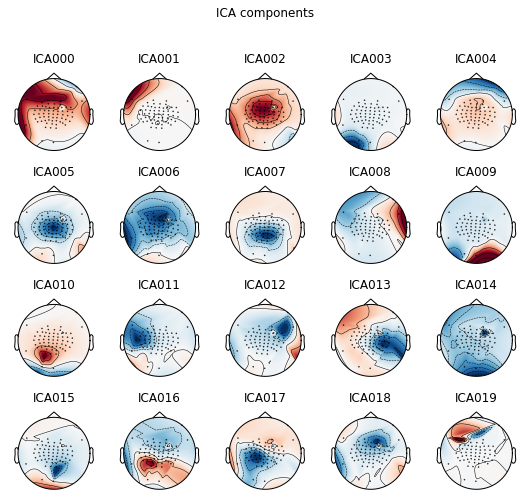

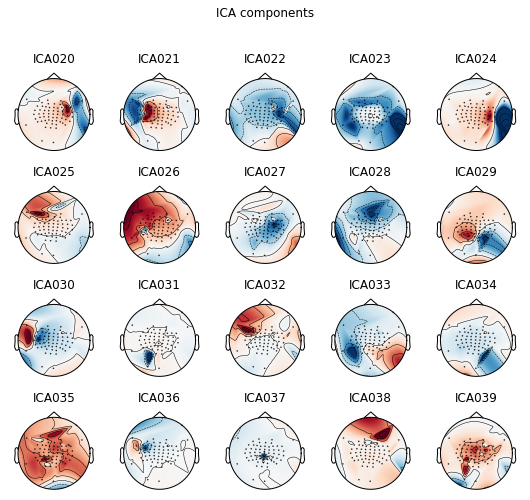

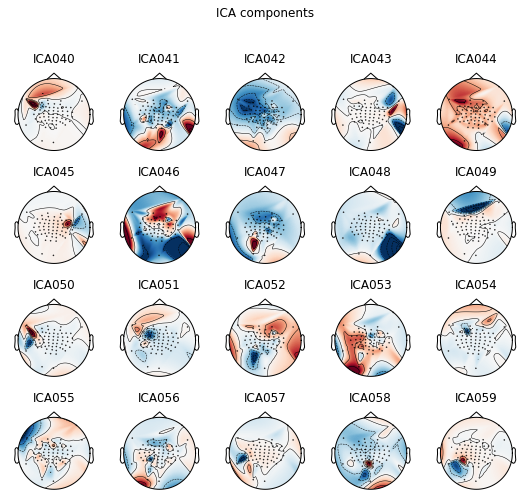

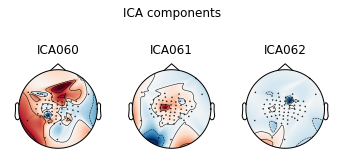

[<Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>,
 <Figure size 540x504 with 20 Axes>,
 <Figure size 352.8x180 with 3 Axes>]

In [27]:
#Plotting all the ICs
ica3.plot_components()

In [28]:
#Detecting artifacts using function based on skewness, kurtosis and variance 
ica1.detect_artifacts(epochs1)
ica2.detect_artifacts(epochs2)
ica3.detect_artifacts(epochs3)
# ica4.detect_artifacts(epochs4)

    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    9, 9, 59
    Removing duplicate indices...
Ready.
    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    6, 15, 11
Ready.
    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    1, 1, 53
    Removing duplicate indices...
Ready.


<ICA  |  epochs decomposition, fit (fastica): 240000 samples, 63 components, channels used: "eeg", 2 sources marked for exclusion>

In [29]:
#Rejected ICs for each trial

'''
Rejecting ICs: http://cognitrn.psych.indiana.edu/busey/temp/eeglabtutorial4.301/maintut/ICA_decomposition.html

This component can be identified as an eye artifact for three reasons: 
1) The smoothly decreasing EEG spectrum (bottom panel) is typical of an eye artifact; 
2) The scalp map shows a strong far-frontal projection typical of eye artifacts; And 
3) it is possible to see individual eye movements in the component erpimage() (top-right panel). 
Eye artifacts are (nearly) always present in EEG datasets. They are usually in leading positions 
in the component array (because they tend to be big) and their scalp topographies (if accounting for lateral eye movements) 
look like component 1 or perhaps (if accounting for eye blinks) like that of component 6 (above).
'''

rejected1 = [6, 11, 15, 39]
rejected2 = [0, 2, 3, 12, 16]
rejected3 = [1, 3, 8, 9, 37, 48, 49, 62]

In [30]:
#Remving the artifacts detected using variance, skewness, kurtosis and manually looking at the ICs
ica1.apply(epochs1, exclude = rejected1)
ica2.apply(epochs2, exclude = rejected2)
ica3.apply(epochs3, exclude = rejected3)
# ica4.apply(epochs4, exclude = rejected4)

Transforming to ICA space (63 components)
Zeroing out 6 ICA components
Transforming to ICA space (63 components)
Zeroing out 8 ICA components
Transforming to ICA space (63 components)
Zeroing out 9 ICA components


<Epochs  |   240 events (all good), 0 - 0.999 sec, baseline off, ~115.5 MB, data loaded,
 '80': 240>

## Defining the EEG preprocessing pipeline

In [31]:
#Delta Power (1-4Hz)
psd1d, freq1d =  mne.time_frequency.psd_multitaper(epochs1, fmin=1., fmax=4.)
psd2d, freq2d =  mne.time_frequency.psd_multitaper(epochs2, fmin=1., fmax=4.)
psd3d, freq3d =  mne.time_frequency.psd_multitaper(epochs3, fmin=1., fmax=4.)
# psd4d, freq4d =  mne.time_frequency.psd_multitaper(epochs4, fmin=1., fmax=4.)

#Theta Power (4-8Hz)
psd1t, freq1t =  mne.time_frequency.psd_multitaper(epochs1, fmin=4., fmax=8.)
psd2t, freq2t =  mne.time_frequency.psd_multitaper(epochs2, fmin=4., fmax=8.)
psd3t, freq3t =  mne.time_frequency.psd_multitaper(epochs3, fmin=4., fmax=8.)
# psd4t, freq4t =  mne.time_frequency.psd_multitaper(epochs4, fmin=4., fmax=8.)

#Alpha power (8-14Hz)
psd1a, freq1a =  mne.time_frequency.psd_multitaper(epochs1, fmin=8., fmax=14.)
psd2a, freq2a =  mne.time_frequency.psd_multitaper(epochs2, fmin=8., fmax=14.)
psd3a, freq3a =  mne.time_frequency.psd_multitaper(epochs3, fmin=8., fmax=14.)
# psd4a, freq4a =  mne.time_frequency.psd_multitaper(epochs4, fmin=8., fmax=14.)

#Beta power (14-31Hz)
psd1b, freq1b =  mne.time_frequency.psd_multitaper(epochs1, fmin=14., fmax=31.)
psd2b, freq2b =  mne.time_frequency.psd_multitaper(epochs2, fmin=14., fmax=31.)
psd3b, freq3b =  mne.time_frequency.psd_multitaper(epochs3, fmin=14., fmax=31.)
# psd4b, freq4b =  mne.time_frequency.psd_multitaper(epochs4, fmin=14., fmax=31.)

#Gamma power (31-50Hz)
psd1g, freq1g =  mne.time_frequency.psd_multitaper(epochs1, fmin=31., fmax=50.)
psd2g, freq2g =  mne.time_frequency.psd_multitaper(epochs2, fmin=31., fmax=50.)
psd3g, freq3g =  mne.time_frequency.psd_multitaper(epochs3, fmin=31., fmax=50.)
# psd4g, freq4g =  mne.time_frequency.psd_multitaper(epochs4, fmin=31., fmax=50.)

#Total Power (1-50Hz)
psd1_all, freq1_all =  mne.time_frequency.psd_multitaper(epochs1, fmin=1., fmax=50.)
psd2_all, freq2_all =  mne.time_frequency.psd_multitaper(epochs2, fmin=1., fmax=50.)
psd3_all, freq3_all =  mne.time_frequency.psd_multitaper(epochs3, fmin=1., fmax=50.)
# psd4_all, freq4_all =  mne.time_frequency.psd_multitaper(epochs4, fmin=1., fmax=50.)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

## ML features extraction from 5 bands and all channels relative power

In [32]:
#Extracting the ML features for the trials 
def MLfeatures(psd_d, psd_t, psd_a, psd_b, psd_g, psd_all):       
    #Power spectrum density
    #Delta power for each of the 63 channels 
    psd_delta = psd_d.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency
    #Theta power for each of the 63 channels 
    psd_theta = psd_t.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency
    #Alpha power for each of the 63 channels 
    psd_alpha = psd_a.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency
    #Beta power for each of the 63 channels 
    psd_beta = psd_b.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency
    #Gamma power for each of the 63 channels 
    psd_gamma = psd_g.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency
    #Total power for each of the 63 channels 
    psd_all = psd_all.mean(0).sum(1) #We average over all epochs and sum over all the Hz frequency  
    
    rel_delta = psd_delta/psd_all
    rel_theta = psd_theta/psd_all
    rel_alpha = psd_alpha/psd_all
    rel_beta = psd_beta/psd_all
    rel_gamma = psd_gamma/psd_all
    return psd_delta, psd_theta, psd_alpha, psd_beta, psd_gamma, psd_all, rel_delta, rel_theta, rel_alpha, rel_beta, rel_gamma

In [33]:
psd1_delta, psd1_theta, psd1_alpha, psd1_beta, psd1_gamma, psd1_all, rel1_delta, rel1_theta, rel1_alpha, rel1_beta, rel1_gamma = MLfeatures(psd1d, psd1t, psd1a, psd1b, psd1g, psd1_all)
psd2_delta, psd2_theta, psd2_alpha, psd2_beta, psd2_gamma, psd2_all, rel2_delta, rel2_theta, rel2_alpha, rel2_beta, rel2_gamma = MLfeatures(psd2d, psd2t, psd2a, psd2b, psd2g, psd2_all)
psd3_delta, psd3_theta, psd3_alpha, psd3_beta, psd3_gamma, psd3_all, rel3_delta, rel3_theta, rel3_alpha, rel3_beta, rel3_gamma = MLfeatures(psd3d, psd3t, psd3a, psd3b, psd3g, psd3_all)
# psd4_delta, psd4_theta, psd4_alpha, psd4_beta, psd4_gamma, psd4_all, rel4_delta, rel4_theta, rel4_alpha, rel4_beta, rel4_gamma = MLfeatures(psd4d, psd4t, psd4a, psd4b, psd4g, psd4_all)

In [34]:
trial1 = numpy.concatenate((rel1_delta, rel1_theta, rel1_alpha, rel1_beta, rel1_gamma))
trial2 = numpy.concatenate((rel2_delta, rel2_theta, rel2_alpha, rel2_beta, rel2_gamma))
trial3 = numpy.concatenate((rel3_delta, rel3_theta, rel3_alpha, rel3_beta, rel3_gamma))
# trial4 = numpy.concatenate((rel4_delta, rel4_theta, rel4_alpha, rel4_beta, rel4_gamma))

In [35]:
channels = list(map_channels.values())
#Total 315 features from each channel and 5 bands 
index0 = ['delta_'+chan for chan in channels] + ['theta_'+chan for chan in channels] + ['alpha_'+chan for chan in channels] + ['beta_'+chan for chan in channels] + ['gamma_'+chan for chan in channels]
features = pandas.DataFrame(numpy.vstack((trial1, trial2, trial3)))
features.columns = index0

In [36]:
features['trialID'] = [3, 4, 2]

In [37]:
features

,delta_Fp1,delta_Fz,delta_F3,delta_F7,delta_LHEye,delta_FC5,delta_FC1,delta_C3,delta_T7,delta_Lmastoid,...,gamma_TP8,gamma_C6,gamma_C2,gamma_FC4,gamma_FT8,gamma_F6,gamma_F2,gamma_AF4,gamma_RVEye,trialID
0,0.806052,0.628752,0.640024,0.673956,0.806532,0.532072,0.537800,0.449805,0.476718,0.809922,...,0.064721,0.088477,0.041924,0.063669,0.093085,0.099084,0.036543,0.026682,0.017967,3
1,0.774238,0.651649,0.651359,0.678428,0.706045,0.575936,0.532247,0.445760,0.368628,0.792894,...,0.110160,0.067143,0.038302,0.044621,0.109874,0.070624,0.037241,0.033572,0.020062,4
2,0.781312,0.606889,0.625281,0.614045,0.707368,0.525821,0.537229,0.453269,0.453223,0.776194,...,0.090528,0.144013,0.055822,0.081629,0.157186,0.132139,0.045246,0.035892,0.024371,2


In [38]:
features.to_csv('HeightControl102_full_trial_features.csv')